We will fit a continuous (linear) mixture of a log-normal and a power law distributions with a simple mixing function:
$$
p(x \mid \alpha, x_{\text{min}}, \mu , \sigma, \phi) = \exp(-\phi x)\left[ \frac{\sqrt{4}}{\text{erfc}\left( \frac{x_{\text{min}}-\mu}{\sqrt{2}\sigma}\right)}\frac{1}{x\sigma\sqrt{2\pi}}\exp\left(-\frac{(\ln x -\mu)^2}{2\sigma^2}\right) \right] + (1-\exp(-\phi x)) \left[ \frac{\alpha-1}{x_{\text{min}}^{1-\alpha}} x^{-\alpha} \right].
$$

In [1]:
source("../power_law_aux.r")
library(poweRlaw)
library(rstan)
rstan_options(auto_write = TRUE)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.9, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Here's the stan code :

In [2]:
writeLines(readLines("../stan/continuous_plaw_lognormal_mixture_varyingDelta.stan"))

functions{
  real truncated_lognormal_lpdf(real x, real mu, real sigma, real x_min){
       real lconst = log(2) - log(erfc( (log(x_min)-mu)/(sqrt(2)*sigma) )) ; 
       real ldens = lognormal_lpdf(x | mu, sigma) ; 
       return(ldens + lconst);
  }
  real power_law_lpdf(real x, real a, real m){
     return ( log(a-1)-log(m) -a *( log(x) - log(m)) );
    }
  real pl_ln_mix_lpdf(real x, real alpha, real x_min, real mu, real sigma, real phi){
    real l1 = truncated_lognormal_lpdf(x | mu, sigma, x_min);
    real l2 = power_law_lpdf(x | alpha, x_min);
    real delta = exp(log1m_exp(-phi * x));
    real ans = log_mix(delta, l1, l2);
    return(ans);
  }
  real density2integrate(real x, real xc, real[] theta, real[] x_r, int[] x_i){
    real alpha = theta[1];
    real x_min = theta[2];
    real mu = theta[3];
    real sigma = theta[4];
    real phi = theta[5];
    real ldens = pl_ln_mix_lpdf(x | alpha, x_min, mu, sigma, phi);
    return(exp(ldens));
  }
}
data{
  int<lower=0> K; // number 

Let's load the compiled model and prepare the data

In [3]:
contplaw.mix <- readRDS("../stan/continuous_plaw_lognormal_mixture_varyingDelta.rds")

In [4]:
data("moby")
the.data <- moby
cdata <- compress_data(the.data)
pl.data <- list(
  K = cdata$K,
  values = cdata$v,
  frequencies = cdata$fs,
  x_min = 1,
  alpha_shape = 10,
  alpha_rate = .1,
  phi_shape = 1,
  phi_rate = 1    
)

In [5]:
posterior.contmix <- sampling(contplaw.mix, data = pl.data, control = list(adapt_delta = .95))


SAMPLING FOR MODEL 'continuous_plaw_lognormal_mixture_varyingDelta' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.0005 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 35.043 seconds (Warm-up)
Chain 1:                22.3224 seconds (Sam

Warning message:
“There were 1000 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [6]:
posterior.contmix

Inference for Stan model: continuous_plaw_lognormal_mixture_varyingDelta.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean  se_mean       sd      2.5%       25%       50%       75%
alpha         7.26     0.90     1.27      5.06      7.25      8.00      8.00
phi           0.43     0.12     0.17      0.14      0.40      0.52      0.53
mu           -3.51     2.07     2.96     -6.34     -5.41     -4.94     -2.34
sigma         2.27     0.84     1.19      0.21      2.02      2.90      2.99
theta[1]      7.26     0.90     1.27      5.06      7.25      8.00      8.00
theta[2]      1.00      NaN     0.00      1.00      1.00      1.00      1.00
theta[3]     -3.51     2.07     2.96     -6.34     -5.41     -4.94     -2.34
theta[4]      2.27     0.84     1.19      0.21      2.02      2.90      2.99
theta[5]      0.43     0.12     0.17      0.14      0.40      0.52      0.53
lconst        1.28     0.01     0.02  

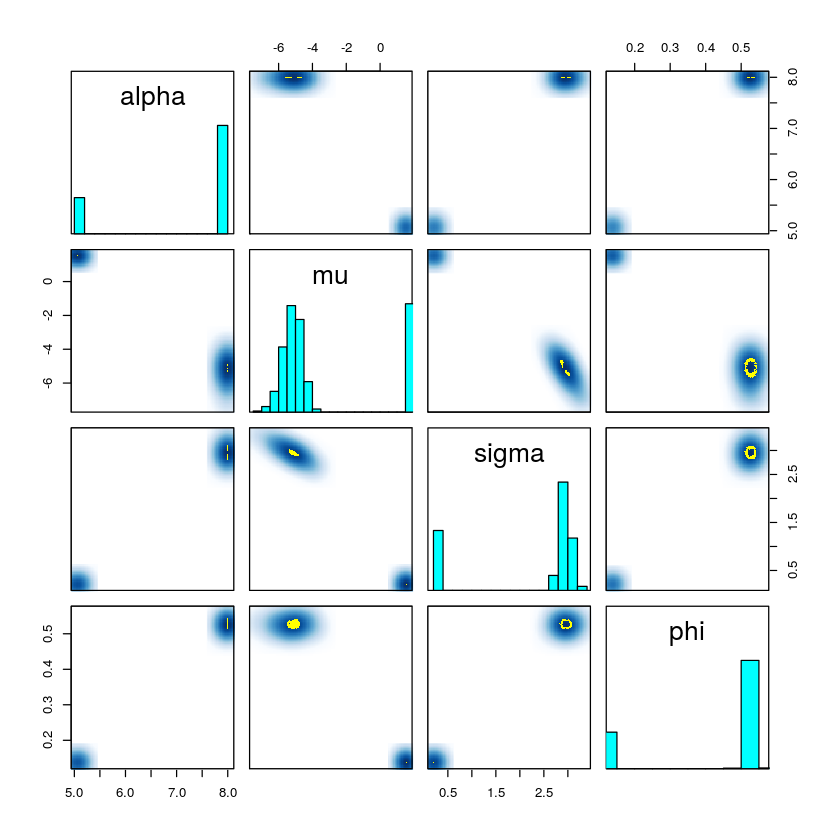

In [8]:
pairs(posterior.contmix, pars = c("alpha", "mu", "sigma", "phi"))

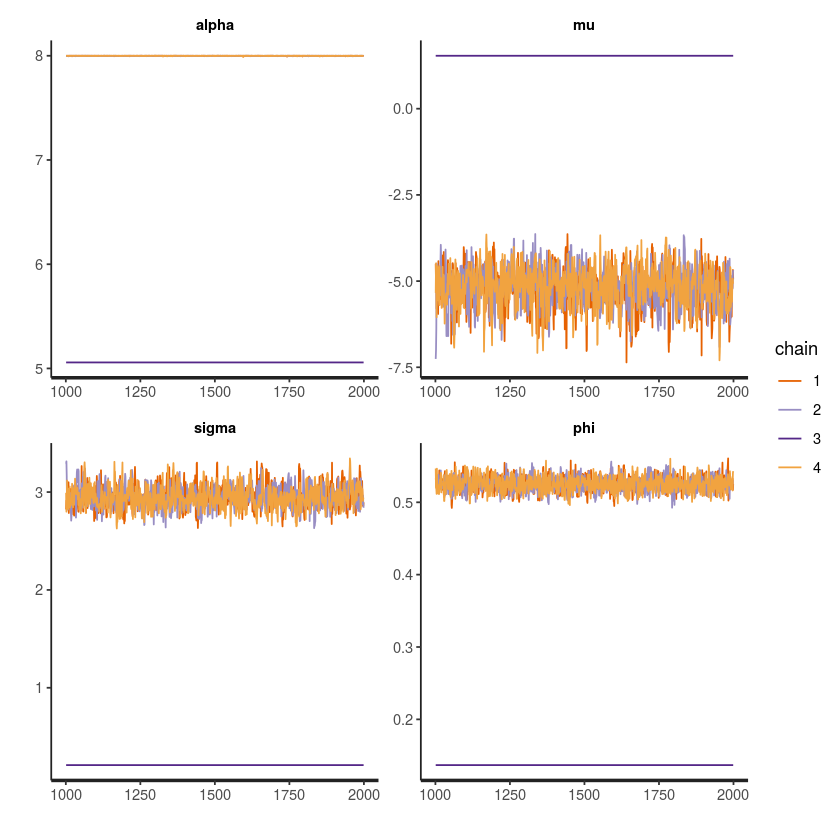

In [9]:
stan_trace(posterior.contmix, pars = c("alpha", "mu", "sigma", "phi"))

Now let's annotate the results and compare with maximum likelihood estimation (MLE).

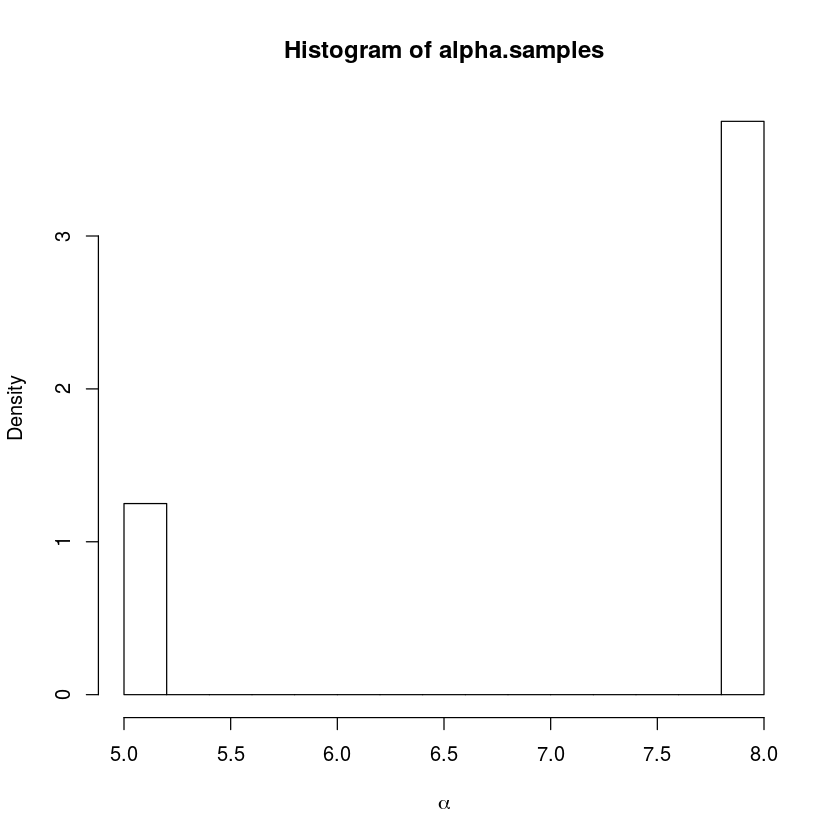

In [10]:
raw <- conpl$new(the.data) 
raw$setXmin(1)
MLE <- estimate_pars(raw)

alpha.samples <- extract(posterior.contmix, 'alpha')$alpha
hist(alpha.samples, probability = TRUE, xlab = expression(alpha))
abline(v = MLE$pars, lwd = 2, lty = 2)

In [ ]:
bridgesampling::bridge_sampler(posterior.contmix)

In [ ]:
raw.ln <- conlnorm$new(the.data)
raw.ln$setXmin(1)
MLE.ln <- estimate_pars(raw.ln)
forplot.ln <- raw.ln
forplot.ln$pars <- MLE.ln$pars

In [ ]:
expose_stan_functions(contplaw.mix)

In [ ]:
mixture_density <- function(x, alpha, xmin, mu, sigma, delta){
    dens <- pl_ln_mix_lpdf(x = x, alpha = alpha, x_min = xmin, mu = mu, sigma = sigma, delta = delta)
    return(exp(dens))
}
mixture_density <- Vectorize(mixture_density)

In [ ]:
mixture_cdf <- function(x, alpha, xmin, mu, sigma, delta){
    1-integrate(function(y) mixture_density(y, alpha, xmin, mu, sigma, delta), xmin, x)$value
}
mixture_cdf <- Vectorize(mixture_cdf)

In [ ]:
integrate(function(x) mixture_density(x, alpha = 8.0, xmin = 1,
                                  mu = 1.65, sigma = 1.11, delta = .5),
1, Inf)

In [ ]:
trunc_lnorm <- function(x) exp( truncated_lognormal_lpdf(x, x_min = 1, mu = 1.65, sigma = 1.11) )
trunc_lnorm <- Vectorize(trunc_lnorm)                               
integrate(trunc_lnorm, 1, Inf)

In [ ]:
mean_pars <- summary(posterior.contmix)$summary[, "mean"]

In [ ]:
forplot <- raw
forplot$pars <- MLE$pars
plot(raw)
lines(forplot, col = 3, lwd = 2)
lines(forplot.ln, col = 2, lwd = 2)
curve(mixture_cdf(x,
                      alpha = mean_pars["alpha"],
                      xmin = 1,
                      mu =  mean_pars["mu"],
                      sigma = mean_pars["sigma"],
                      delta =  mean_pars["delta"]),
    1, max(pl.data$values), col = 5, add = TRUE)
legend(x = "topright",
       legend = c("Power law", "Log-normal", "Mixture"),
       col = c(3, 2, 5), lwd = 2, bty = 'n')